In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import torch; torch.set_default_dtype(torch.float64)
import torch.nn as nn
import torch.optim as optim
import copy
import math

# Stochastic Block Model (SBM) Graph Generation via the GSO

In [2]:
def sbm(n, c, p_intra, p_inter):
    
    # assign a community to each node
    community = np.repeat(list(range(c)), np.ceil(n / c))

    # make sure community vector has size n
    community = community[0:n]

    # make it a column vector
    community = np.expand_dims(community, 1)


    # generate a boolean matrix indicating whether two nodes 
    # are in the same community
    intra = community == community.T

    # generate a boolean matrix indicating whether two nodes 
    # are in different communities
    inter = np.logical_not(intra)

    # generate a matrix with random entries between 0 and 1
    random = np.random.random((n, n))

    # generate a triangular matrix with zeros below the main diagonal
    # because the SBM graph is symmetric, we only have to assign weights 
    # to the upper triangular part of the adjacency matrix,
    # and later copy them to the lower triangular part
    tri = np.tri(n, k=-1)


    # initialize adjacency matrix
    graph = np.zeros((n, n))

    # assign intra-community edges
    graph[np.logical_and.reduce([tri, intra, random < p_intra])] = 1

    # assign inter-community edges
    graph[np.logical_and.reduce([tri, inter, random < p_inter])] = 1

    # make the adjacency matrix symmetric
    graph += graph.T 

    return graph

def normalize_gso(gso):
    
    # obtain eigenvalues
    eigenvalues, _ = np.linalg.eig(gso) 

    # normalize by eigenvalue with largest absolute value
    return gso / np.max(np.abs(eigenvalues))


S = sbm(n=50, c=5, p_intra=0.6, p_inter=0.2)
S = normalize_gso(S)

# Data Generation and Training/Test Sets

In [3]:
def generate_diffusion(gso, n_samples, n_sources):

    # get the number of nodes
    n = gso.shape[0]

    # initialize the tensor used to store the samples
    # shape is n_samples x n x time x 1 features
    z = np.zeros((n_samples, n, 5, 1))

    for i in range(n_samples):

        # pick n_sources at random from n nodes
        sources = np.random.choice(n, n_sources, replace=False)

        # define z_0 for each sample
        z[i, sources, 0, 0] = np.random.uniform(0, 10, n_sources)

    # noise mean and variance
    mu = np.zeros(n)
    sigma = np.eye(n) * 1e-3

    for t in range(4):

        # generate noise
        noise = np.random.multivariate_normal(mu, sigma, n_samples)

        # generate z_t
        print(z[:, :, t].shape)
        z[:, :, t + 1] = gso @ z[:, :, t] + np.expand_dims(noise, -1)
        
    # transpose dimensions so shape is n_samples x time x n x 1 feature
    z = z.transpose((0, 2, 1, 3))
    
    # squeeze feature dimension, as there is only 1 feature
    return z.squeeze()


z = generate_diffusion(S, 2100, 10)
# n_samples x time x n
print(z.shape)

(2100, 50, 1)
(2100, 50, 1)
(2100, 50, 1)
(2100, 50, 1)
(2100, 5, 50)


In [4]:
def data_from_diffusion(z):
    
    # Permute the samples in z (x is a multi-dimensional array, it is only shuffled along its first index)
    z = np.random.permutation(z)
    
    # define the output tensor
    y = np.expand_dims(z[:, 0, :], 1)
    print(y.shape)
    
    # initialize the input tensor
    x = np.zeros(y.shape)
    
    # define the input tensor as x = z_4
    for i, sample in enumerate(z):
        x[i] = sample[4]
   
    print(x.shape)
    # squeeze time dimension     
    return x.squeeze(), y.squeeze()

x, y = data_from_diffusion(z)
print(x.shape, y.shape)

(2100, 1, 50)
(2100, 1, 50)
(2100, 50) (2100, 50)


In [5]:
def split_data(x, y, splits = (2000, 100)):

    # define the initial index of each set (training/test)
    splits = np.cumsum([0] + list(splits))
    splits = (splits * x.shape[0] / splits[-1]).astype(int)

    # return training and test data as tuples
    return ((x[splits[i]:splits[i + 1]], y[splits[i]:splits[i + 1]]) for i in range(len(splits) - 1))

nTrain = 2000
nTest = 100

trainData, testData = split_data(x, y, (nTrain, nTest))
xTrain = trainData[0]
yTrain = trainData[1]
xTest = testData[0]
yTest = testData[1]

xTrain = torch.tensor(xTrain)
yTrain = torch.tensor(yTrain)
xTest = torch.tensor(xTest)
yTest = torch.tensor(yTest)

print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

torch.Size([2000, 50])
torch.Size([2000, 50])
torch.Size([100, 50])
torch.Size([100, 50])


# Implementing the Graph Convolutional Filter Architecture;

We need functions that implements the shift-and-sum operation.

We need functions such as the torch.nn.Module that defines the graph filter as a learning architecture.

Note that all the architectures assume that the bias is 0;

In [6]:
def FilterFunction(h, S, x):
    K = h.shape[0] # number of filter taps
    B = x.shape[0] # batch size
    N = x.shape[1] # number of nodes

    x = x.reshape([B, 1, N])
    S = S.reshape([1, N, N])
    z = x

    for k in range(1, K):
        # diffusion step, S^k*x
        x = torch.matmul(x, S)
        xS = x.reshape([B, 1, N]) 

        # concatenate the S^k*x in the tensor z
        z = torch.cat((z, xS), dim=1) 

    # multiply z and h in the concatenation dimension
    y = torch.matmul(z.permute(0, 2, 1).reshape([B, N, K]), h)

    return y

class GraphFilter(nn.Module):
    def __init__(self, gso, k):
        
        # Initialize parent
        super().__init__()
        
        # Save filter hyperparameters
        self.gso = torch.tensor(gso)
        self.n = gso.shape[0]
        self.k = k
        
        # Define and initialize learnable weights
        self.weight = nn.Parameter(torch.randn(self.k))
        self.reset_parameters()
        
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.k)
        self.weight.data.uniform_(-stdv, stdv)

    def forward(self, x):
        return FilterFunction(self.weight, self.gso, x)
    
graphFilter = GraphFilter(S, 8) 

#  Loss function

In [7]:
loss = nn.MSELoss()

# Training of the Graph Convolutional Filter


Epoch 1

    (E:  1, B:   1) 
	 Graph Filter: 5.8551 [T] 5.3755 [V]

    (E:  1, B:   6) 
	 Graph Filter: 5.7759 [T] 5.3618 [V]

Epoch 2

    (E:  2, B:   1) 
	 Graph Filter: 5.8682 [T] 5.3838 [V]

    (E:  2, B:   6) 
	 Graph Filter: 5.5422 [T] 5.3777 [V]

Epoch 3

    (E:  3, B:   1) 
	 Graph Filter: 5.4804 [T] 5.3543 [V]

    (E:  3, B:   6) 
	 Graph Filter: 5.5814 [T] 5.3475 [V]

Epoch 4

    (E:  4, B:   1) 
	 Graph Filter: 5.7271 [T] 5.3490 [V]

    (E:  4, B:   6) 
	 Graph Filter: 5.5879 [T] 5.3481 [V]

Epoch 5

    (E:  5, B:   1) 
	 Graph Filter: 5.5367 [T] 5.3442 [V]

    (E:  5, B:   6) 
	 Graph Filter: 5.7071 [T] 5.3410 [V]

Epoch 6

    (E:  6, B:   1) 
	 Graph Filter: 5.5209 [T] 5.3386 [V]

    (E:  6, B:   6) 
	 Graph Filter: 5.6299 [T] 5.3366 [V]

Epoch 7

    (E:  7, B:   1) 
	 Graph Filter: 5.7361 [T] 5.3347 [V]

    (E:  7, B:   6) 
	 Graph Filter: 5.6420 [T] 5.3325 [V]

Epoch 8

    (E:  8, B:   1) 
	 Graph Filter: 5.7341 [T] 5.3303 [V]

    (E:  8, B:   6) 
	 Grap

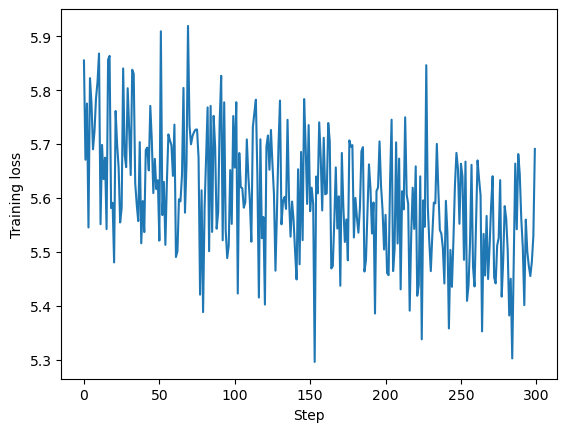

Final evaluation results
 Graph Filter: 5.2312 [Best] 5.2290 [Last]


In [8]:
validationInterval = 5

nEpochs = 30
batchSize = 200
learningRate = 0.05

nValid = int(np.floor(0.01*nTrain))
xValid = xTrain[0:nValid,:]
yValid = yTrain[0:nValid,:]
xTrain = xTrain[nValid:,:]
yTrain = yTrain[nValid:,:]
nTrain = xTrain.shape[0]

# Declaring the optimizers for each architectures
optimizer = optim.Adam(graphFilter.parameters(), lr=learningRate)

if nTrain < batchSize:
    nBatches = 1
    batchSize = [nTrain]
elif nTrain % batchSize != 0:
    nBatches = np.ceil(nTrain/batchSize).astype(np.int64)
    batchSize = [batchSize] * nBatches
    while sum(batchSize) != nTrain:
        batchSize[-1] -= 1
else:
    nBatches = np.int(nTrain/batchSize)
    batchSize = [batchSize] * nBatches
batchIndex = np.cumsum(batchSize).tolist()
batchIndex = [0] + batchIndex

epoch = 0 # epoch counter

# Store the training...
lossTrain = dict()
lossValid = dict()
# ...and test variables
lossTestBest = dict()
lossTestLast = dict()

bestModel = dict()

lossTrain = []
lossValid = []
    
while epoch < nEpochs:
    randomPermutation = np.random.permutation(nTrain)
    idxEpoch = [int(i) for i in randomPermutation]
    print("")
    print("Epoch %d" % (epoch+1))

    batch = 0 
    
    while batch < nBatches:
        # Determine batch indices
        thisBatchIndices = idxEpoch[batchIndex[batch]
                                    : batchIndex[batch+1]]
        
        # Get the samples in this batch
        xTrainBatch = xTrain[thisBatchIndices,:]
        yTrainBatch = yTrain[thisBatchIndices,:]

        if (epoch * nBatches + batch) % validationInterval == 0:
            print("")
            print("    (E: %2d, B: %3d)" % (epoch+1, batch+1),end = ' ')
            print("")
        
       
        # Reset gradients
        graphFilter.zero_grad()

        # Obtain the output of the architectures
        yHatTrainBatch = graphFilter(xTrainBatch)

        # Compute loss
        lossValueTrain = loss(yHatTrainBatch, yTrainBatch)

        # Compute gradients
        lossValueTrain.backward()

        # Optimize
        optimizer.step()
        
        lossTrain += [lossValueTrain.item()]
        
        # Print:
        if (epoch * nBatches + batch) % validationInterval == 0:
            with torch.no_grad():
                # Obtain the output of the GNN
                yHatValid = graphFilter(xValid)
    
            # Compute loss
            lossValueValid = loss(yHatValid, yValid)
            
            lossValid += [lossValueValid.item()]

            print("\t Graph Filter: %6.4f [T]" % (
                    lossValueTrain) + " %6.4f [V]" % (
                    lossValueValid))
            
            # Saving the best model so far
            if len(lossValid) > 1:
                if lossValueValid <= min(lossValid):
                    bestModel =  copy.deepcopy(graphFilter)
            else:
                bestModel =  copy.deepcopy(graphFilter)
                    
        batch+=1
        
    epoch+=1
    
print("")

################################
############# PLOT #############
################################
 
plt.plot(lossTrain)
plt.ylabel('Training loss')
plt.xlabel('Step')
plt.show()
   
################################
########## EVALUATION ##########
################################

print("Final evaluation results")

with torch.no_grad():
    yHatTest = graphFilter(xTest)
lossTestLast = loss(yHatTest, yTest)
lossTestLast = lossTestLast.item()
with torch.no_grad():
    yHatTest = bestModel(xTest)
lossTestBest = loss(yHatTest, yTest)
lossTestBest = lossTestBest.item()

print(" Graph Filter: %6.4f [Best]" % (
                    lossTestBest) + " %6.4f [Last]" % (
                    lossTestLast))

# Implmenting the Graph Perceptron Architecture;

In [9]:
class GraphPerceptron(nn.Module):
    def __init__(self, gso, k, sigma):
        super().__init__()
        self.gso = torch.tensor(gso)
        self.n = gso.shape[0]
        self.k = k
        self.sigma = sigma
        self.weight = nn.Parameter(torch.randn(self.k))
        self.reset_parameters()
        
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.k)
        self.weight.data.uniform_(-stdv, stdv)

    def forward(self, x):
        y = FilterFunction(self.weight, self.gso, x)
        y = self.sigma(y)
        return y    
    
graphPerceptron = GraphPerceptron(S, 8, nn.ReLU())    

# Training of the Graph Perceptron;


Epoch 1

    (E:  1, B:   1) 
	 Graph Perceptron: 6.6190 [T] 6.4445 [V]

    (E:  1, B:   6) 
	 Graph Perceptron: 5.8045 [T] 6.2125 [V]

Epoch 2

    (E:  2, B:   1) 
	 Graph Perceptron: 5.5729 [T] 6.1161 [V]

    (E:  2, B:   6) 
	 Graph Perceptron: 5.7670 [T] 6.0560 [V]

Epoch 3

    (E:  3, B:   1) 
	 Graph Perceptron: 5.5813 [T] 6.0758 [V]

    (E:  3, B:   6) 
	 Graph Perceptron: 5.8042 [T] 6.0703 [V]

Epoch 4

    (E:  4, B:   1) 
	 Graph Perceptron: 5.6519 [T] 6.0526 [V]

    (E:  4, B:   6) 
	 Graph Perceptron: 5.7195 [T] 6.0512 [V]

Epoch 5

    (E:  5, B:   1) 
	 Graph Perceptron: 5.5678 [T] 6.0525 [V]

    (E:  5, B:   6) 
	 Graph Perceptron: 5.7601 [T] 6.0481 [V]

Epoch 6

    (E:  6, B:   1) 
	 Graph Perceptron: 5.8454 [T] 6.0448 [V]

    (E:  6, B:   6) 
	 Graph Perceptron: 5.6052 [T] 6.0422 [V]

Epoch 7

    (E:  7, B:   1) 
	 Graph Perceptron: 5.5421 [T] 6.0401 [V]

    (E:  7, B:   6) 
	 Graph Perceptron: 5.7119 [T] 6.0381 [V]

Epoch 8

    (E:  8, B:   1) 
	 Graph Pe

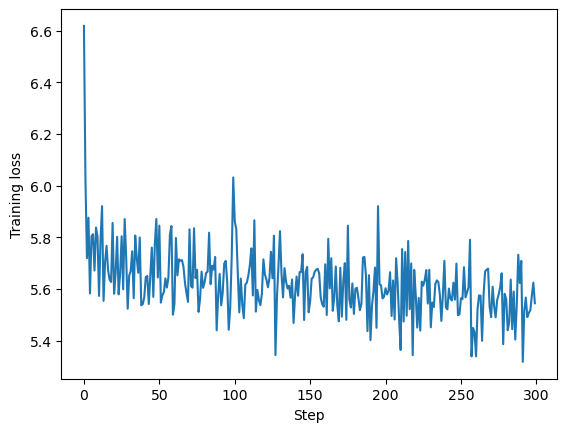

Final evaluation results
 Graph Perceptron: 5.2536 [Best] 5.2516 [Last]


In [10]:
validationInterval = 5

nEpochs = 30
batchSize = 200
learningRate = 0.05

nValid = int(np.floor(0.01*nTrain))
xValid = xTrain[0:nValid,:]
yValid = yTrain[0:nValid,:]
xTrain = xTrain[nValid:,:]
yTrain = yTrain[nValid:,:]
nTrain = xTrain.shape[0]

# Declaring the optimizers for each architectures
optimizer = optim.Adam(graphPerceptron.parameters(), lr=learningRate)

if nTrain < batchSize:
    nBatches = 1
    batchSize = [nTrain]
elif nTrain % batchSize != 0:
    nBatches = np.ceil(nTrain/batchSize).astype(np.int64)
    batchSize = [batchSize] * nBatches
    while sum(batchSize) != nTrain:
        batchSize[-1] -= 1
else:
    nBatches = np.int(nTrain/batchSize)
    batchSize = [batchSize] * nBatches
batchIndex = np.cumsum(batchSize).tolist()
batchIndex = [0] + batchIndex

epoch = 0 # epoch counter

# Store the training...
lossTrain = dict()
lossValid = dict()
# ...and test variables
lossTestBest = dict()
lossTestLast = dict()

bestModel = dict()

lossTrain = []
lossValid = []
    
while epoch < nEpochs:
    randomPermutation = np.random.permutation(nTrain)
    idxEpoch = [int(i) for i in randomPermutation]
    print("")
    print("Epoch %d" % (epoch+1))

    batch = 0 
    
    while batch < nBatches:
        # Determine batch indices
        thisBatchIndices = idxEpoch[batchIndex[batch]
                                    : batchIndex[batch+1]]
        
        # Get the samples in this batch
        xTrainBatch = xTrain[thisBatchIndices,:]
        yTrainBatch = yTrain[thisBatchIndices,:]

        if (epoch * nBatches + batch) % validationInterval == 0:
            print("")
            print("    (E: %2d, B: %3d)" % (epoch+1, batch+1),end = ' ')
            print("")
        
       
        # Reset gradients
        graphPerceptron.zero_grad()

        # Obtain the output of the architectures
        yHatTrainBatch = graphPerceptron(xTrainBatch)

        # Compute loss
        lossValueTrain = loss(yHatTrainBatch, yTrainBatch)

        # Compute gradients
        lossValueTrain.backward()

        # Optimize
        optimizer.step()
        
        lossTrain += [lossValueTrain.item()]
        
        # Print:
        if (epoch * nBatches + batch) % validationInterval == 0:
            with torch.no_grad():
                # Obtain the output of the GNN
                yHatValid = graphPerceptron(xValid)
    
            # Compute loss
            lossValueValid = loss(yHatValid, yValid)
            
            lossValid += [lossValueValid.item()]

            print("\t Graph Perceptron: %6.4f [T]" % (
                    lossValueTrain) + " %6.4f [V]" % (
                    lossValueValid))
            
            # Saving the best model so far
            if len(lossValid) > 1:
                if lossValueValid <= min(lossValid):
                    bestModel =  copy.deepcopy(graphPerceptron)
            else:
                bestModel =  copy.deepcopy(graphPerceptron)
                    
        batch+=1
        
    epoch+=1
    
print("")

################################
############# PLOT #############
################################
 
plt.plot(lossTrain)
plt.ylabel('Training loss')
plt.xlabel('Step')
plt.show()
   
################################
########## EVALUATION ##########
################################

print("Final evaluation results")

with torch.no_grad():
    yHatTest = graphPerceptron(xTest)
lossTestLast = loss(yHatTest, yTest)
lossTestLast = lossTestLast.item()
with torch.no_grad():
    yHatTest = bestModel(xTest)
lossTestBest = loss(yHatTest, yTest)
lossTestBest = lossTestBest.item()

print(" Graph Perceptron: %6.4f [Best]" % (
                    lossTestBest) + " %6.4f [Last]" % (
                    lossTestLast))

# Implementing the Multi-layer GNN architecture

In [11]:
class MLGNN(nn.Module):
    def __init__(self, gso, l, k, sigma):
        super().__init__()
        layers = []
        for layer in range(l):
            layers.append(GraphPerceptron(gso, k[layer], sigma))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        y = self.layers(x)
        return y

MLGNN = MLGNN(S, 2, [8, 1], nn.ReLU()) 

# Training of the Multi-layer GNN;


Epoch 1

    (E:  1, B:   1) 
	 MLGNN: 6.6507 [T] 5.7702 [V]

    (E:  1, B:   6) 
	 MLGNN: 6.3920 [T] 5.7702 [V]

Epoch 2

    (E:  2, B:   1) 
	 MLGNN: 6.5657 [T] 5.7702 [V]

    (E:  2, B:   6) 
	 MLGNN: 6.6642 [T] 5.7702 [V]

Epoch 3

    (E:  3, B:   1) 
	 MLGNN: 6.5924 [T] 5.7702 [V]

    (E:  3, B:   6) 
	 MLGNN: 6.7981 [T] 5.7702 [V]

Epoch 4

    (E:  4, B:   1) 
	 MLGNN: 6.6036 [T] 5.7702 [V]

    (E:  4, B:   6) 
	 MLGNN: 6.7368 [T] 5.7702 [V]

Epoch 5

    (E:  5, B:   1) 
	 MLGNN: 6.6862 [T] 5.7702 [V]

    (E:  5, B:   6) 
	 MLGNN: 6.6540 [T] 5.7702 [V]

Epoch 6

    (E:  6, B:   1) 
	 MLGNN: 6.6042 [T] 5.7702 [V]

    (E:  6, B:   6) 
	 MLGNN: 6.8239 [T] 5.7702 [V]

Epoch 7

    (E:  7, B:   1) 
	 MLGNN: 6.7131 [T] 5.7702 [V]

    (E:  7, B:   6) 
	 MLGNN: 6.6540 [T] 5.7702 [V]

Epoch 8

    (E:  8, B:   1) 
	 MLGNN: 6.6358 [T] 5.7702 [V]

    (E:  8, B:   6) 
	 MLGNN: 6.9098 [T] 5.7702 [V]

Epoch 9

    (E:  9, B:   1) 
	 MLGNN: 6.5417 [T] 5.7702 [V]

    (E:  9, B:   

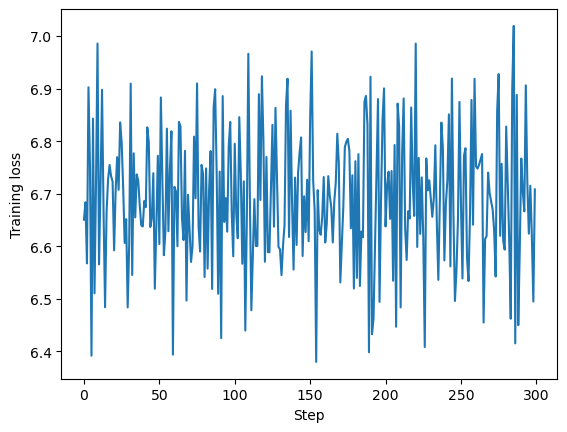

Final evaluation results
 MLGNN: 6.3325 [Best] 6.3325 [Last]


In [12]:
validationInterval = 5

nEpochs = 30
batchSize = 200
learningRate = 0.05

nValid = int(np.floor(0.01*nTrain))
xValid = xTrain[0:nValid,:]
yValid = yTrain[0:nValid,:]
xTrain = xTrain[nValid:,:]
yTrain = yTrain[nValid:,:]
nTrain = xTrain.shape[0]

# Declaring the optimizers for each architectures
optimizer = optim.Adam(MLGNN.parameters(), lr=learningRate)

if nTrain < batchSize:
    nBatches = 1
    batchSize = [nTrain]
elif nTrain % batchSize != 0:
    nBatches = np.ceil(nTrain/batchSize).astype(np.int64)
    batchSize = [batchSize] * nBatches
    while sum(batchSize) != nTrain:
        batchSize[-1] -= 1
else:
    nBatches = np.int(nTrain/batchSize)
    batchSize = [batchSize] * nBatches
batchIndex = np.cumsum(batchSize).tolist()
batchIndex = [0] + batchIndex

epoch = 0 # epoch counter

# Store the training...
lossTrain = dict()
lossValid = dict()
# ...and test variables
lossTestBest = dict()
lossTestLast = dict()

bestModel = dict()

lossTrain = []
lossValid = []
    
while epoch < nEpochs:
    randomPermutation = np.random.permutation(nTrain)
    idxEpoch = [int(i) for i in randomPermutation]
    print("")
    print("Epoch %d" % (epoch+1))

    batch = 0 
    
    while batch < nBatches:
        # Determine batch indices
        thisBatchIndices = idxEpoch[batchIndex[batch]
                                    : batchIndex[batch+1]]
        
        # Get the samples in this batch
        xTrainBatch = xTrain[thisBatchIndices,:]
        yTrainBatch = yTrain[thisBatchIndices,:]

        if (epoch * nBatches + batch) % validationInterval == 0:
            print("")
            print("    (E: %2d, B: %3d)" % (epoch+1, batch+1),end = ' ')
            print("")
        
       
        # Reset gradients
        MLGNN.zero_grad()

        # Obtain the output of the architectures
        yHatTrainBatch = MLGNN(xTrainBatch)

        # Compute loss
        lossValueTrain = loss(yHatTrainBatch, yTrainBatch)

        # Compute gradients
        lossValueTrain.backward()

        # Optimize
        optimizer.step()
        
        lossTrain += [lossValueTrain.item()]
        
        # Print:
        if (epoch * nBatches + batch) % validationInterval == 0:
            with torch.no_grad():
                # Obtain the output of the GNN
                yHatValid = MLGNN(xValid)
    
            # Compute loss
            lossValueValid = loss(yHatValid, yValid)
            
            lossValid += [lossValueValid.item()]

            print("\t MLGNN: %6.4f [T]" % (
                    lossValueTrain) + " %6.4f [V]" % (
                    lossValueValid))
            
            # Saving the best model so far
            if len(lossValid) > 1:
                if lossValueValid <= min(lossValid):
                    bestModel =  copy.deepcopy(MLGNN)
            else:
                bestModel =  copy.deepcopy(MLGNN)
                    
        batch+=1
        
    epoch+=1
    
print("")

################################
############# PLOT #############
################################
 
plt.plot(lossTrain)
plt.ylabel('Training loss')
plt.xlabel('Step')
plt.show()
   
################################
########## EVALUATION ##########
################################

print("Final evaluation results")

with torch.no_grad():
    yHatTest = MLGNN(xTest)
lossTestLast = loss(yHatTest, yTest)
lossTestLast = lossTestLast.item()
with torch.no_grad():
    yHatTest = bestModel(xTest)
lossTestBest = loss(yHatTest, yTest)
lossTestBest = lossTestBest.item()

print(" MLGNN: %6.4f [Best]" % (
                    lossTestBest) + " %6.4f [Last]" % (
                    lossTestLast))

# Multiple Feature Filters and GNNs in general.

In [13]:
def FilterFunction(h, S, x):
    
    # Number of output features
    F = h.shape[0]
    
    # Number of filter taps
    K = h.shape[1]
    
    # Number of input features
    G = h.shape[2]
    
    # Number of nodes
    N = S.shape[1]
    
    # Batch size
    B = x.shape[0]

    # Create concatenation dimension and initialize concatenation tensor z
    x = x.reshape([B, 1, G, N])
    S = S.reshape([1, N, N])
    z = x
    
    # Loop over the number of filter taps
    for k in range(1, K):
        
        # S*x
        x = torch.matmul(x, S)
        
        # Reshape
        xS = x.reshape([B, 1, G, N])
        
        # Concatenate
        z = torch.cat((z, xS), dim=1)
    
    # Multiply by h
    y = torch.matmul(z.permute(0, 3, 1, 2).reshape([B, N, K*G]), h.reshape([F, K*G]).permute(1, 0)).permute(0, 2, 1)
    return y

class GraphFilter(nn.Module):
    def __init__(self, gso, k, f_in, f_out):
        super().__init__()
        self.gso = torch.tensor(gso)
        self.n = gso.shape[0]
        self.k = k
        self.f_in = f_in
        self.f_out = f_out
        self.weight = nn.Parameter(torch.randn(self.f_out, self.k, self.f_in))
        self.reset_parameters()
        
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.f_in * self.k)
        self.weight.data.uniform_(-stdv, stdv)

    def forward(self, x):
        return FilterFunction(self.weight, self.gso, x)

In [16]:
class GNN(nn.Module):
    def __init__(self, gso, l, k, f, sigma):
        super().__init__()
        self.gso = torch.tensor(gso)
        self.n = gso.shape[0]
        self.l = l
        self.k = k
        self.f = f
        self.sigma = sigma
        
        gml = []
        for layer in range(l):
            gml.append(GraphFilter(gso, k[layer], f[layer], f[layer+1]))
            gml.append(sigma)
        
        self.gml = nn.Sequential(*gml)
        
    def forward(self, x):
        return self.gml(x)

MLgraphFilter = nn.Sequential(GraphFilter(S, 8, 1, 32), GraphFilter(S, 1, 32, 1))    
GNN2ly = GNN(S, 2, [8, 1], [1, 32, 1], nn.ReLU()) 
GNN3ly = GNN(S, 3, [5,5,1], [1,16,4,1], nn.ReLU())


architectures = dict()

# Multi-feature graph filter
architectures['MFGraphFilter'] = MLgraphFilter

# GNN, 2 layer
architectures['GNN 2 layer  '] = GNN2ly

# GNN, 3 layers
architectures['GNN 3 layer  '] = GNN3ly

<ipython-input-19-27d4e87ee15a>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xTrain = torch.tensor(xTrain)
<ipython-input-19-27d4e87ee15a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yTrain = torch.tensor(yTrain)
<ipython-input-19-27d4e87ee15a>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xTest = torch.tensor(xTest)
<ipython-input-19-27d4e87ee15a>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tens


Epoch 1

    (E:  1, B:   1) 
	MFGraphFilter: 7.2665 [T] 6.1721 [V]
	GNN 2 layer  : 6.8523 [T] 6.0586 [V]
	GNN 3 layer  : 6.7006 [T] 5.1517 [V]

    (E:  1, B:   6) 
	MFGraphFilter: 6.2052 [T] 5.4400 [V]
	GNN 2 layer  : 6.7087 [T] 6.0586 [V]
	GNN 3 layer  : 6.0271 [T] 5.5875 [V]

Epoch 2

    (E:  2, B:   1) 
	MFGraphFilter: 5.6868 [T] 5.2555 [V]
	GNN 2 layer  : 6.5617 [T] 6.0586 [V]
	GNN 3 layer  : 5.8276 [T] 5.2488 [V]

    (E:  2, B:   6) 
	MFGraphFilter: 5.8163 [T] 5.2386 [V]
	GNN 2 layer  : 6.7807 [T] 6.0586 [V]
	GNN 3 layer  : 5.9621 [T] 5.2623 [V]

Epoch 3

    (E:  3, B:   1) 
	MFGraphFilter: 5.6605 [T] 5.1957 [V]
	GNN 2 layer  : 6.6375 [T] 6.0586 [V]
	GNN 3 layer  : 5.7136 [T] 5.2385 [V]

    (E:  3, B:   6) 
	MFGraphFilter: 5.5811 [T] 5.1711 [V]
	GNN 2 layer  : 6.5603 [T] 6.0586 [V]
	GNN 3 layer  : 5.5750 [T] 5.1459 [V]

Epoch 4

    (E:  4, B:   1) 
	MFGraphFilter: 5.6264 [T] 5.1527 [V]
	GNN 2 layer  : 6.6479 [T] 6.0586 [V]
	GNN 3 layer  : 5.6474 [T] 5.1431 [V]

    (E:  4,


    (E: 30, B:   6) 
	MFGraphFilter: 5.2333 [T] 4.7470 [V]
	GNN 2 layer  : 6.6659 [T] 6.0586 [V]
	GNN 3 layer  : 5.1811 [T] 4.7002 [V]



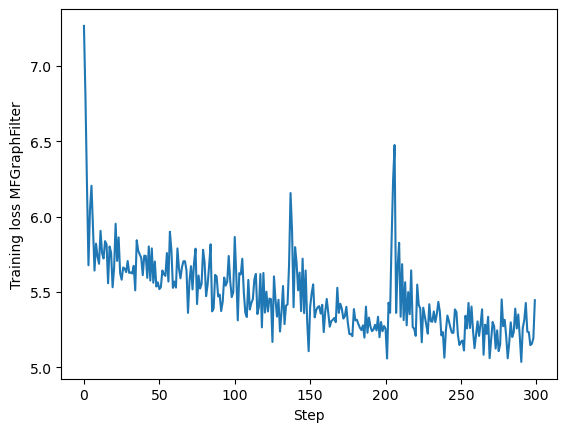

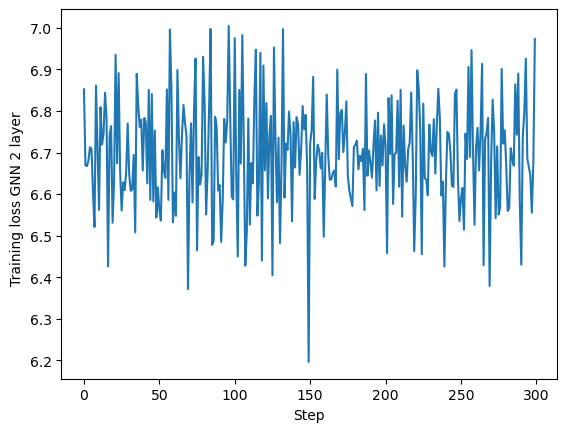

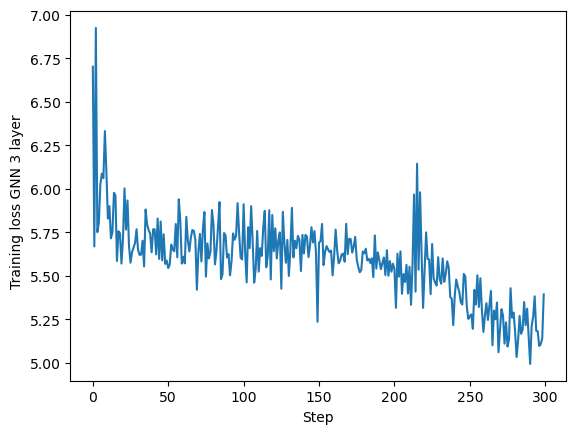

Final evaluation results
 MFGraphFilter: 5.0159 [Best] 5.0165 [Last]
 GNN 2 layer  : 6.3325 [Best] 6.3325 [Last]
 GNN 3 layer  : 4.9772 [Best] 4.9778 [Last]


In [19]:
N = S.shape[0]
xTrain = torch.tensor(xTrain)
xTrain = xTrain.reshape([-1,1,N])
yTrain = torch.tensor(yTrain)
yTrain = yTrain.reshape([-1,1,N])

xTest = torch.tensor(xTest)
xTest = xTest.reshape([-1,1,N])
yTest = torch.tensor(yTest)
yTest = yTest.reshape([-1,1,N])


################################
########### TRAINING ###########
################################

validationInterval = 5

nEpochs = 30
batchSize = 200
learningRate = 0.05

nValid = int(np.floor(0.01*nTrain))
xValid = xTrain[0:nValid,:,:]
yValid = yTrain[0:nValid,:,:]
xTrain = xTrain[nValid:,:,:]
yTrain = yTrain[nValid:,:,:]
nTrain = xTrain.shape[0]

# Declaring the optimizers for each architectures
optimizers = dict()
for key in architectures.keys():
    optimizers[key] = optim.Adam(architectures[key].parameters(), lr=learningRate)

if nTrain < batchSize:
    nBatches = 1
    batchSize = [nTrain]
elif nTrain % batchSize != 0:
    nBatches = np.ceil(nTrain/batchSize).astype(np.int64)
    batchSize = [batchSize] * nBatches
    while sum(batchSize) != nTrain:
        batchSize[-1] -= 1
else:
    nBatches = np.int(nTrain/batchSize)
    batchSize = [batchSize] * nBatches
batchIndex = np.cumsum(batchSize).tolist()
batchIndex = [0] + batchIndex

epoch = 0 # epoch counter

# Store the training...
lossTrain = dict()
costTrain = dict()
lossValid = dict()
costValid = dict()
# ...and test variables
lossTestBest = dict()
costTestBest = dict()
lossTestLast = dict()
costTestLast = dict()

bestModel = dict()

for key in architectures.keys():
    lossTrain[key] = []
    costTrain[key] = []
    lossValid[key] = []
    costValid[key] = []
    
while epoch < nEpochs:
    randomPermutation = np.random.permutation(nTrain)
    idxEpoch = [int(i) for i in randomPermutation]
    print("")
    print("Epoch %d" % (epoch+1))

    batch = 0 
    
    while batch < nBatches:
        # Determine batch indices
        thisBatchIndices = idxEpoch[batchIndex[batch]
                                    : batchIndex[batch+1]]
        
        # Get the samples in this batch
        xTrainBatch = xTrain[thisBatchIndices,:,:]
        yTrainBatch = yTrain[thisBatchIndices,:,:]

        if (epoch * nBatches + batch) % validationInterval == 0:
            print("")
            print("    (E: %2d, B: %3d)" % (epoch+1, batch+1),end = ' ')
            print("")
        
        for key in architectures.keys():
            # Reset gradients
            architectures[key].zero_grad()

            # Obtain the output of the architectures
            yHatTrainBatch = architectures[key](xTrainBatch)

            # Compute loss
            lossValueTrain = loss(yHatTrainBatch.squeeze(), yTrainBatch.squeeze())
    
            # Compute gradients
            lossValueTrain.backward()
    
            # Optimize
            optimizers[key].step()

            costValueTrain = lossValueTrain.item()
            
            lossTrain[key] += [lossValueTrain.item()]
            costTrain[key] += [costValueTrain]
            
            # Print:
            if (epoch * nBatches + batch) % validationInterval == 0:
                with torch.no_grad():
                    # Obtain the output of the GNN
                    yHatValid = architectures[key](xValid)
        
                # Compute loss
                lossValueValid = loss(yHatValid.squeeze(), yValid.squeeze())

                # Compute accuracy:
                costValueValid = lossValueValid.item()
                
                lossValid[key] += [lossValueValid.item()]
                costValid[key] += [costValueValid]

                print("\t" + key + ": %6.4f [T]" % (
                        costValueTrain) + " %6.4f [V]" % (
                        costValueValid))
                
                # Saving the best model so far
                if len(costValid[key]) > 1:
                    if costValueValid <= min(costValid[key]):
                        bestModel[key] =  copy.deepcopy(architectures[key])
                else:
                    bestModel[key] =  copy.deepcopy(architectures[key])
                    
        batch+=1
        
    epoch+=1
    
print("")
 
 
################################
############# PLOT #############
################################
 
for key in architectures.keys():
    plt.plot(lossTrain[key])
    plt.ylabel('Training loss ' + key)
    plt.xlabel('Step')
    plt.show()
  
################################
########## EVALUATION ##########
################################

print("Final evaluation results")

for key in architectures.keys():
    with torch.no_grad():
        yHatTest = architectures[key](xTest)
    lossTestLast[key] = loss(yHatTest.squeeze(), yTest.squeeze())
    costTestLast[key] = lossTestLast[key].item()
    with torch.no_grad():
        yHatTest = bestModel[key](xTest)
    lossTestBest[key] = loss(yHatTest.squeeze(), yTest.squeeze())
    costTestBest[key] = lossTestBest[key].item()
    
    print(" " + key + ": %6.4f [Best]" % (
                        costTestBest[key]) + " %6.4f [Last]" % (
                        costTestLast[key]))

# Revising the architectures to assume that bias is non-zero;

In [20]:
def FilterFunction(h, S, x, b=None):
    F = h.shape[0]
    K = h.shape[1]
    G = h.shape[2]

    N = S.shape[1]
    B = x.shape[0]

    x = x.reshape([B, 1, G, N])
    S = S.reshape([1, N, N])
    z = x
    for k in range(1, K):
        x = torch.matmul(x, S)
        xS = x.reshape([B, 1, G, N])
        z = torch.cat((z, xS), dim=1)
    y = torch.matmul(z.permute(0, 3, 1, 2).reshape([B, N, K*G]), h.reshape([F, K*G]).permute(1, 0)).permute(0, 2, 1)
    
    if b is not None:
        y = y + b
    return y
    
    
class GraphFilter(nn.Module):
    def __init__(self, gso, k, f_in, f_out, bias):
        super().__init__()
        self.gso = torch.tensor(gso)
        self.n = gso.shape[0]
        self.k = k
        self.f_in = f_in
        self.f_out = f_out
        if bias:
            self.bias = nn.parameter.Parameter(torch.Tensor(self.f_out, 1))
        self.weight = nn.Parameter(torch.randn(self.f_out, self.k, self.f_in))
        self.reset_parameters()
        
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.f_in * self.k)
        self.weight.data.uniform_(-stdv, stdv)
        
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, x):
        return FilterFunction(self.weight, self.gso, x, self.bias)
    
# 4.2
        
class GNN(nn.Module):
    def __init__(self, gso, l, k, f, sigma, bias):
        super().__init__()
        self.gso = torch.tensor(gso)
        self.n = gso.shape[0]
        self.l = l
        self.k = k
        self.f = f
        self.sigma = sigma
        self.bias = bias
        
        gml = []
        for layer in range(l):
            gml.append(GraphFilter(gso,k[layer],f[layer],f[layer+1], bias))
            gml.append(sigma)
        
        self.gml = nn.Sequential(*gml)
        
    def forward(self, x):
        return self.gml(x)
    

# Comparing all the architectures for this dataset;

In [21]:
architectures = dict()

# Linear parametrization    
linearParam = torch.nn.Linear(N,N, bias = True)
architectures['LinearLayer  '] = linearParam

# Fully connected neural network   
fcNet = nn.Sequential(torch.nn.Linear(N,25, bias=True), nn.ReLU(), torch.nn.Linear(25,N, bias=True), nn.ReLU())
architectures['FCLayer      '] = fcNet

# Multi-feature graph filter
MLgraphFilter = nn.Sequential(GraphFilter(S,8,1,32,True), GraphFilter(S,1,32,1,True))
architectures['MFGraphFilter'] = MLgraphFilter

# GNN, 1 layer
GNN1Ly = GNN(S,2,[8,1],[1,32,1],nn.ReLU(),True)
architectures['GNN 1 layer  '] = GNN1Ly

# GNN, 2 layers
GNN2Ly = GNN(S,3,[5,5,1],[1,16,4,1],nn.ReLU(),True)
architectures['GNN 2 layer  '] = GNN2Ly


################################
########### TRAINING ###########
################################

validationInterval = 5

nEpochs = 30
batchSize = 200
learningRate = 0.05

nValid = int(np.floor(0.01*nTrain))
xValid = xTrain[0:nValid,:,:]
yValid = yTrain[0:nValid,:,:]
xTrain = xTrain[nValid:,:,:]
yTrain = yTrain[nValid:,:,:]
nTrain = xTrain.shape[0]

# Declaring the optimizers for each architectures
optimizers = dict()
for key in architectures.keys():
    optimizers[key] = optim.Adam(architectures[key].parameters(), lr=learningRate)

if nTrain < batchSize:
    nBatches = 1
    batchSize = [nTrain]
elif nTrain % batchSize != 0:
    nBatches = np.ceil(nTrain/batchSize).astype(np.int64)
    batchSize = [batchSize] * nBatches
    while sum(batchSize) != nTrain:
        batchSize[-1] -= 1
else:
    nBatches = np.int(nTrain/batchSize)
    batchSize = [batchSize] * nBatches
batchIndex = np.cumsum(batchSize).tolist()
batchIndex = [0] + batchIndex

epoch = 0 # epoch counter

# Store the training...
lossTrain = dict()
costTrain = dict()
lossValid = dict()
costValid = dict()
# ...and test variables
lossTestBest = dict()
costTestBest = dict()
lossTestLast = dict()
costTestLast = dict()

bestModel = dict()

for key in architectures.keys():
    lossTrain[key] = []
    costTrain[key] = []
    lossValid[key] = []
    costValid[key] = []
    
while epoch < nEpochs:
    randomPermutation = np.random.permutation(nTrain)
    idxEpoch = [int(i) for i in randomPermutation]
    print("")
    print("Epoch %d" % (epoch+1))

    batch = 0 
    
    while batch < nBatches:
        # Determine batch indices
        thisBatchIndices = idxEpoch[batchIndex[batch]
                                    : batchIndex[batch+1]]
        
        # Get the samples in this batch
        xTrainBatch = xTrain[thisBatchIndices,:,:]
        yTrainBatch = yTrain[thisBatchIndices,:,:]

        if (epoch * nBatches + batch) % validationInterval == 0:
            print("")
            print("    (E: %2d, B: %3d)" % (epoch+1, batch+1),end = ' ')
            print("")
        
        for key in architectures.keys():
            # Reset gradients
            architectures[key].zero_grad()

            # Obtain the output of the architectures
            yHatTrainBatch = architectures[key](xTrainBatch)

            # Compute loss
            lossValueTrain = loss(yHatTrainBatch.squeeze(), yTrainBatch.squeeze())
    
            # Compute gradients
            lossValueTrain.backward()
    
            # Optimize
            optimizers[key].step()

            costValueTrain = lossValueTrain.item()
            
            lossTrain[key] += [lossValueTrain.item()]
            costTrain[key] += [costValueTrain]
            
            # Print:
            if (epoch * nBatches + batch) % validationInterval == 0:
                with torch.no_grad():
                    # Obtain the output of the GNN
                    yHatValid = architectures[key](xValid)
        
                # Compute loss
                lossValueValid = loss(yHatValid.squeeze(), yValid.squeeze())

                # Compute accuracy:
                costValueValid = lossValueValid.item()
                
                lossValid[key] += [lossValueValid.item()]
                costValid[key] += [costValueValid]

                print("\t" + key + ": %6.4f [T]" % (
                        costValueTrain) + " %6.4f [V]" % (
                        costValueValid))
                
                # Saving the best model so far
                if len(costValid[key]) > 1:
                    if costValueValid <= min(costValid[key]):
                        bestModel[key] =  copy.deepcopy(architectures[key])
                else:
                    bestModel[key] =  copy.deepcopy(architectures[key])
                    
        batch+=1
        
    epoch+=1
    
print("")
 
   
################################
########## EVALUATION ##########
################################

print("Final evaluation results")

for key in architectures.keys():
    with torch.no_grad():
        yHatTest = architectures[key](xTest)
    lossTestLast[key] = loss(yHatTest.squeeze(), yTest.squeeze())
    costTestLast[key] = lossTestLast[key].item()
    with torch.no_grad():
        yHatTest = bestModel[key](xTest)
    lossTestBest[key] = loss(yHatTest.squeeze(), yTest.squeeze())
    costTestBest[key] = lossTestBest[key].item()
    
    print(" " + key + ": %6.4f [Best]" % (
                        costTestBest[key]) + " %6.4f [Last]" % (
                        costTestLast[key]))


Epoch 1

    (E:  1, B:   1) 
	LinearLayer  : 7.2551 [T] 7.7068 [V]
	FCLayer      : 6.7262 [T] 7.4962 [V]
	MFGraphFilter: 7.6007 [T] 5.9598 [V]
	GNN 1 layer  : 6.5528 [T] 5.6906 [V]
	GNN 2 layer  : 6.9078 [T] 6.2795 [V]

    (E:  1, B:   6) 
	LinearLayer  : 6.8130 [T] 5.8329 [V]
	FCLayer      : 6.5928 [T] 5.9507 [V]
	MFGraphFilter: 6.1553 [T] 5.3543 [V]
	GNN 1 layer  : 5.8743 [T] 5.4187 [V]
	GNN 2 layer  : 6.8146 [T] 6.2795 [V]

Epoch 2

    (E:  2, B:   1) 
	LinearLayer  : 6.3045 [T] 5.6408 [V]
	FCLayer      : 6.2744 [T] 5.6719 [V]
	MFGraphFilter: 5.7209 [T] 5.3790 [V]
	GNN 1 layer  : 5.7690 [T] 5.3929 [V]
	GNN 2 layer  : 6.7556 [T] 6.2795 [V]

    (E:  2, B:   6) 
	LinearLayer  : 6.2519 [T] 5.5612 [V]
	FCLayer      : 6.1834 [T] 5.6159 [V]
	MFGraphFilter: 5.8154 [T] 5.3891 [V]
	GNN 1 layer  : 5.8426 [T] 5.3665 [V]
	GNN 2 layer  : 6.8808 [T] 6.2795 [V]

Epoch 3

    (E:  3, B:   1) 
	LinearLayer  : 5.9139 [T] 5.4844 [V]
	FCLayer      : 5.9788 [T] 5.5938 [V]
	MFGraphFilter: 5.6461 [T] 


Epoch 20

    (E: 20, B:   1) 
	LinearLayer  : 5.6038 [T] 5.4104 [V]
	FCLayer      : 5.8877 [T] 5.5592 [V]
	MFGraphFilter: 5.3207 [T] 5.0485 [V]
	GNN 1 layer  : 5.2513 [T] 4.9944 [V]
	GNN 2 layer  : 6.6480 [T] 6.2795 [V]

    (E: 20, B:   6) 
	LinearLayer  : 5.6295 [T] 5.3499 [V]
	FCLayer      : 5.9037 [T] 5.5511 [V]
	MFGraphFilter: 5.2858 [T] 5.0339 [V]
	GNN 1 layer  : 5.2232 [T] 4.9756 [V]
	GNN 2 layer  : 6.6209 [T] 6.2795 [V]

Epoch 21

    (E: 21, B:   1) 
	LinearLayer  : 5.6719 [T] 5.3244 [V]
	FCLayer      : 6.0311 [T] 5.5424 [V]
	MFGraphFilter: 5.3521 [T] 5.0183 [V]
	GNN 1 layer  : 5.2631 [T] 4.9690 [V]
	GNN 2 layer  : 6.7552 [T] 6.2795 [V]

    (E: 21, B:   6) 
	LinearLayer  : 5.7711 [T] 5.4125 [V]
	FCLayer      : 6.0590 [T] 5.5412 [V]
	MFGraphFilter: 5.4175 [T] 5.0453 [V]
	GNN 1 layer  : 5.3655 [T] 4.9792 [V]
	GNN 2 layer  : 6.8468 [T] 6.2795 [V]

Epoch 22

    (E: 22, B:   1) 
	LinearLayer  : 5.7270 [T] 5.4184 [V]
	FCLayer      : 6.0390 [T] 5.5496 [V]
	MFGraphFilter: 5.3365 [